# Getting Started with Chronos-2

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)



**Chronos-2** is a foundation model for time series forecasting that builds on [Chronos](https://arxiv.org/abs/2403.07815) and [Chronos-Bolt](https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/). It offers significant improvements in capabilities and can handle diverse forecasting scenarios not supported by earlier models.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |

🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors (see [AutoGluon tutorial](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html#incorporating-the-covariates)). This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

More details about Chronos-2 are available in the [technical report](https://www.arxiv.org/abs/2510.15821).

In [1]:
%pip install 'chronos-forecasting>=2.2'

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install 'matplotlib'

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

2026-01-27 18:31:30.200685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

## Forecasting with Covariates

Chronos-2 can leverage covariates to improve forecast accuracy. We demonstrate this with two real-world examples.

### Energy Price Forecasting

Forecast hourly energy prices for the next day using historical prices and day-ahead forecasts of load (Ampirion Load Forecast) and renewable energy generation (PV+Wind Forecast).

In [5]:
# Energy price forecasting configuration
target = "target"  # Column name containing the values to forecast (energy prices)
prediction_length = 24  # Number of hours to forecast ahead
id_column = "id"  # Column identifying different time series (countries/regions)
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "DE"  # Specific time series to visualize (Germany)

# Load historical energy prices and past values of covariates
energy_context_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet"
)
energy_context_df[timestamp_column] = pd.to_datetime(energy_context_df[timestamp_column])
display(energy_context_df.head(10))

# Load future values of covariates
energy_test_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet"
)
energy_test_df[timestamp_column] = pd.to_datetime(energy_test_df[timestamp_column])
energy_future_df = energy_test_df.drop(columns=target)
display(energy_future_df.head(10))

,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902
5,DE,2012-01-09 05:00:00,36.130001,19348.75,2676.350098
6,DE,2012-01-09 06:00:00,43.020000,23058.50,2533.847412
7,DE,2012-01-09 07:00:00,59.029999,25349.25,2555.867432
8,DE,2012-01-09 08:00:00,64.480003,26336.75,2818.969238
9,DE,2012-01-09 09:00:00,58.720001,26321.00,3386.187012


,id,timestamp,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2017-12-12 00:00:00,20483.00,22284.005859
1,DE,2017-12-12 01:00:00,19849.75,22878.673828
2,DE,2017-12-12 02:00:00,19638.25,23632.283203
3,DE,2017-12-12 03:00:00,19895.25,24635.945312
4,DE,2017-12-12 04:00:00,20338.00,25584.935547
5,DE,2017-12-12 05:00:00,21395.25,26489.929688
6,DE,2017-12-12 06:00:00,24072.75,27345.125000
7,DE,2017-12-12 07:00:00,26332.50,27729.585938
8,DE,2017-12-12 08:00:00,27329.75,27705.193359
9,DE,2017-12-12 09:00:00,27344.25,28046.484375


In [6]:
# Generate predictions with covariates
energy_pred_df = pipeline.predict_df(
    energy_context_df,
    future_df=energy_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
display(energy_pred_df.head())

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,22.242924,18.673727,22.242924,25.403454
1,DE,2017-12-12 01:00:00,target,19.525620,14.904280,19.525620,23.316601
2,DE,2017-12-12 02:00:00,target,17.415375,12.209061,17.415375,21.776983
3,DE,2017-12-12 03:00:00,target,16.979269,11.165129,16.979269,21.435225
4,DE,2017-12-12 04:00:00,target,18.058655,12.096771,18.058655,23.166647


In [7]:
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

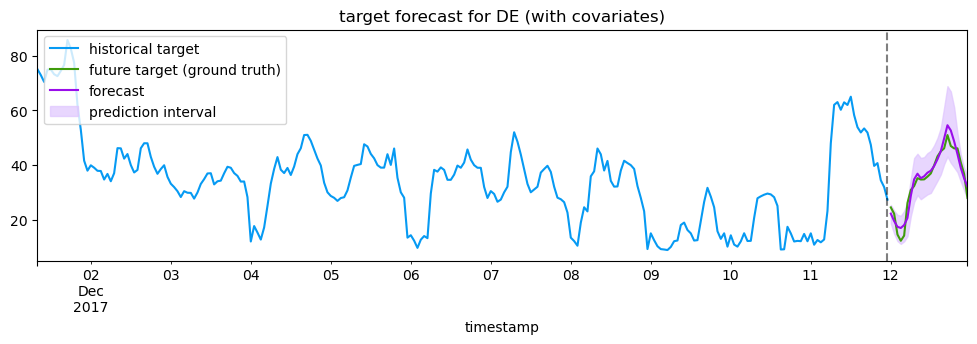

In [8]:
# Visualize forecast with covariates
plot_forecast(
    energy_context_df,
    energy_pred_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)

The comparison shows that Chronos-2 makes reasonable but imprecise predictions in univariate mode. However, with covariates, Chronos-2 effectively uses the load and renewable generation forecasts, producing significantly more accurate predictions.